In [1]:
import tensorflow as tf
import cv2
import os
import numpy as np
import time
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
emotion_labels = ['anger', 'contempt', 'disgust', 'fear', 'happy',
                  'neutral', 'sad', 'surprise', 'uncertain']
colors = [(0, 0, 255), (0, 255, 255), (0, 255, 0), 
                 (255, 0, 0), (255, 255, 0), (255, 255, 255), 
                 (0, 0, 0), (255, 0, 255), (128, 128, 128)]

# путь к файлу модели
file_path = "C:\\Users\\Admin\\ML. Средний уровень\\Cource\\skillbox-computer-vision-project\\tf_model_48_Adam06_64"

In [3]:
# # Вариант 1
# # Предсказания делаются непосредственно моделью через метод predict.
# class Fer_Model_Predict:
#     def __init__(self, model_path):
#         self.model = tf.keras.models.load_model(model_path)

#     def predict(self, image):
#         preprocessed = preprocess(image)
#         predictions = self.model.predict(preprocessed)          
#         return get_emotion(predictions)

# # out FPS 4-5

# Вариант 2
# используется не сама Keras-модель, а ее конвертированный в TFLite вариант для работы с interpreter.
class Fer_Model:
    def __init__(self, model_path):
        # Модель конвертируется в формат TensorFlow Lite с помощью TFLiteConverter.
        converter = tf.lite.TFLiteConverter.from_saved_model(model_path)
        tflite_model = converter.convert()
        with open('converted_model.tflite', 'wb') as f:
            f.write(tflite_model)
        # Создается объект Interpreter для интерпретации конвертированной модели.
        self.interpreter = tf.lite.Interpreter(model_path='converted_model.tflite')

    # Предсказания делаются уже не моделью напрямую, а через interpreter:
    def predict(self, image):
        preprocessed = preprocess(image).astype(np.float32)
        # Выделяются тензоры входа/выхода
        self.interpreter.allocate_tensors() 
        input_details = self.interpreter.get_input_details()
        output_details = self.interpreter.get_output_details()
        # Устанавливается входной тензор
        self.interpreter.set_tensor(input_details[0]['index'], preprocessed)
        self.interpreter.invoke() # Выполняется invoke interpreter'а
        # Получается выходной тензор
        predictions = self.interpreter.get_tensor(output_details[0]['index'])
        return get_emotion(predictions)
    
# out FPS 6-11

In [4]:
def detect_faces(frame):
    face_detector = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    grayscale_image = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_detector.detectMultiScale(grayscale_image)
    return faces

def preprocess(image):
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img_input = cv2.resize(img_gray, (48,48)) / 255.0
    img_input = np.expand_dims(img_input, axis=0)
    img_input = np.expand_dims(img_input, axis=-1)
    return img_input

def get_emotion(predictions):
    return emotion_labels[np.argmax(predictions)]

In [5]:
def plot_emotion_data(df):
  # Преобразование столбца 'Time'
  df['Time'] = pd.to_datetime(df['Time'])
  # График зависимости эмоции от времени
  fig, ax = plt.subplots(figsize=(10, 6))
  ax.plot(df['Time'], df['Emotion'], 'o-')
  # Настройка осей и заголовка  
  ax.set_xlabel('Time')
  ax.set_ylabel('Emotion')
  ax.set_title('Emotion over Time')

  # Круговая диаграмма распределения эмоций
  emotion_counts = df['Emotion'].value_counts()
  fig, ax = plt.subplots(figsize=(6, 6))
  patches, texts, autotexts = ax.pie(emotion_counts,  
                                     labels=emotion_counts.index, 
                                     autopct='%1.1f%%')
  ax.set_title('Distribution of Emotions')
  for text in texts:
      text.set_text('')
  ax.legend(patches, emotion_counts.index, 
            title='Emotions', 
            loc='center left', 
            bbox_to_anchor=(1, 0.5))
  plt.show()

In [7]:
cap = cv2.VideoCapture(0)
fps_count = 0
fps_time = time.time()
# проверка камеры
if not cap.isOpened():
    print("Не удалось открыть камеру")
else:
    print("Камера запущена")
    print(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# проверка наличия файла модели
if os.path.exists(file_path):
    model = Fer_Model(file_path)
else:
    print("Файл модели не найден.")

df = pd.DataFrame(columns=['Time', 'Emotion'])

predicted = ""

while cap.isOpened():
    ret, frame = cap.read()
    if frame is not None:        
        cv2.imshow("facial emotion recognition", frame)
        faces = detect_faces(frame)
        # отрисовка рамок с предсказанием
        for i, (x, y, w, h) in enumerate(faces):
            if predicted in emotion_labels:
                cv2.rectangle(frame, (x, y), (x+w, y+h), 
                              colors[emotion_labels.index(predicted)], 2) 
                cv2.putText(frame, predicted, (x, y-10),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.9,
                           colors[emotion_labels.index(predicted)], 2)
            else:
                colors[emotion_labels.index('uncertain')], 2  # Default color if emotion is not in the list
            # Отображение количества обнаруженных лиц
            print("Найдено {} число лиц".format(len(faces)))
            print("Массив faces: {}".format(faces))  
            # Отображение рамок
            cv2.imshow("facial emotion recognition", frame) 
            predicted = model.predict(frame)
            fps_count += 1
            current_time = time.time()

            df = df.append({'Time': datetime.now().strftime("%H:%M:%S.%f")[:-3], 'Emotion': predicted}, 
                           ignore_index=True)

            if current_time - fps_time >= 1:
                print("FPS: ", fps_count)
                fps_time = current_time
                fps_count = 0    
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
cap.release()
cv2.destroyAllWindows()
df.to_csv('emotions.csv')

Камера запущена
480.0
Найдено 1 лицо/лиц
Массив faces: [[245  11 129 129]]
FPS:  1
Найдено 1 лицо/лиц
Массив faces: [[244  14 128 128]]
Найдено 1 лицо/лиц
Массив faces: [[243  12 131 131]]
Найдено 1 лицо/лиц
Массив faces: [[245  13 129 129]]
Найдено 1 лицо/лиц
Массив faces: [[246  12 129 129]]
Найдено 1 лицо/лиц
Массив faces: [[245  11 131 131]]
Найдено 1 лицо/лиц
Массив faces: [[246  12 130 130]]
Найдено 1 лицо/лиц
Массив faces: [[246  12 129 129]]
Найдено 1 лицо/лиц
Массив faces: [[246  12 129 129]]
FPS:  8
Найдено 1 лицо/лиц
Массив faces: [[245  12 129 129]]
Найдено 1 лицо/лиц
Массив faces: [[244  13 130 130]]
Найдено 1 лицо/лиц
Массив faces: [[244  12 132 132]]
Найдено 1 лицо/лиц
Массив faces: [[245  12 131 131]]
Найдено 1 лицо/лиц
Массив faces: [[247  13 128 128]]
Найдено 1 лицо/лиц
Массив faces: [[247  13 129 129]]
Найдено 1 лицо/лиц
Массив faces: [[246  13 131 131]]
FPS:  7
Найдено 1 лицо/лиц
Массив faces: [[247  13 130 130]]
Найдено 1 лицо/лиц
Массив faces: [[248  13 130 130]]


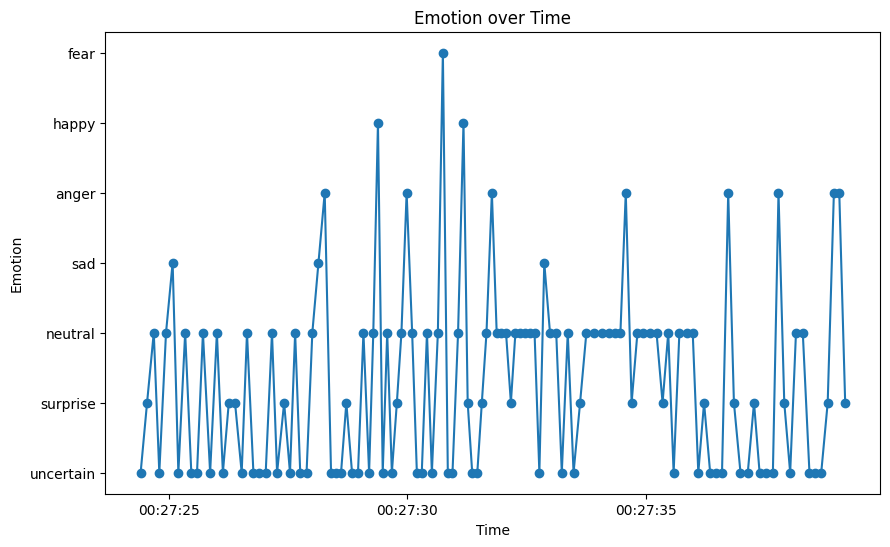

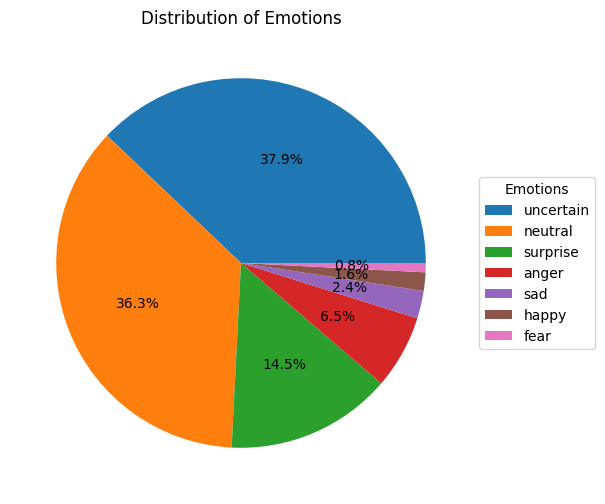

,Time,Emotion
0,2024-04-28 00:27:24.397,uncertain
1,2024-04-28 00:27:24.532,surprise
2,2024-04-28 00:27:24.673,neutral
3,2024-04-28 00:27:24.789,uncertain
4,2024-04-28 00:27:24.930,neutral
...,...,...
119,2024-04-28 00:27:38.687,uncertain
120,2024-04-28 00:27:38.823,surprise
121,2024-04-28 00:27:38.953,anger
122,2024-04-28 00:27:39.066,anger


In [8]:
plot_emotion_data(df)
df